# Loan Default Prediction Model
This notebooks presents a machine learning model that predicts if a customer is likely to be approved for a loan. The input features include length of credit history, age, education, income, employment and home ownership. The model uses a synthetic data from Kaggle.  
The steps in the notebook include:

- Data download and preparation
- Data Exploration and correlation analysis
- Data preprocessing
- Model tuning
- Model Evaluation
- Explainable AI

#Data Download and preparation

In [74]:
import kagglehub
import shutil
import os
'''
#run to download data
temp_path = kagglehub.dataset_download('taweilo/loan-approval-classification-data')
data_folder = os.path.join('/content/', temp_path.split(os.sep)[-3])
shutil.copytree(temp_path, data_folder)
print(f"Downloaded and copied to: {data_folder}")
'''

'\n#run to download data\ntemp_path = kagglehub.dataset_download(\'taweilo/loan-approval-classification-data\')\ndata_folder = os.path.join(\'/content/\', temp_path.split(os.sep)[-3])\nshutil.copytree(temp_path, data_folder)\nprint(f"Downloaded and copied to: {data_folder}")\n'

In [75]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import lightgbm as lg
from sklearn.metrics import f1_score, accuracy_score, classification_report
import lightgbm as lg
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

data_folder =  "/content/loan-approval-classification-data"
all_data = pd.read_csv(f"{data_folder}/loan_data.csv", low_memory=False)

#remove spaces from a categorical column (lightgbm requirement)
all_data["person_education"] = all_data["person_education"].str.replace(' ', '_')


#Explore data


We can get basic stats such as the mean and range (minimum and maximum) of numerical columns

In [76]:
all_data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000



From exploring data we can see that the data has 45000 rows and 13 rows. Data types match their expected values

In [77]:
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

From histograms, we can see that some columns like income have outliers, so we'd need some scaling. Also, target variable is imbalanced with positive to negative classes in 1:3.5 ratio

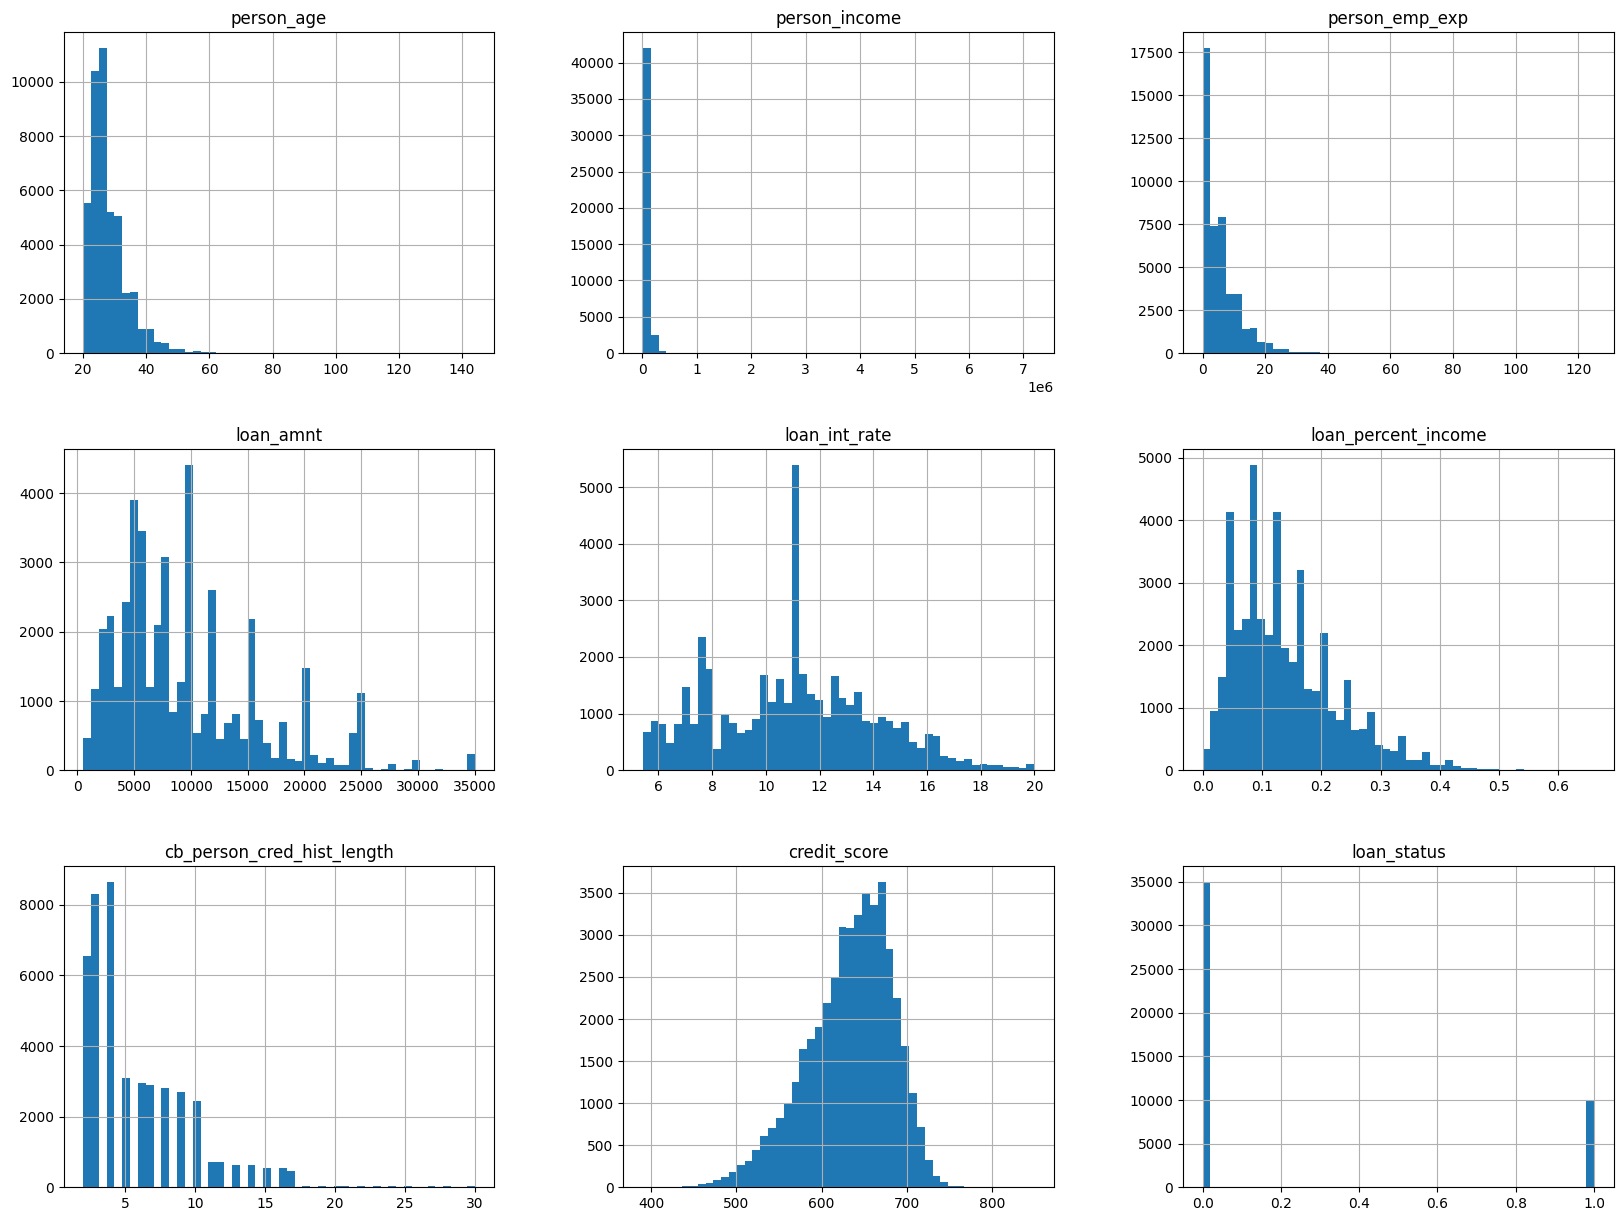

In [78]:
all_data.hist(bins=50, figsize=(20,15))
plt.show()

Get numerical/categorical columns

In [79]:
# target variable: 1 = approved; 0 = rejected
target = "loan_status"
#categorical columns
cat_vars = train_data.select_dtypes(exclude='number').columns
num_vars = [x for x in train_data.columns if x not in cat_vars]

display(train_data[cat_vars])
print(" Categorical variables: \n", list(cat_vars))
print("\n\n Numerical variables: \n", num_vars)



,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
22689,male,Bachelor,MORTGAGE,VENTURE,Yes
983,female,Master,RENT,MEDICAL,No
43632,female,Associate,RENT,VENTURE,No
654,male,Bachelor,OWN,VENTURE,Yes
39930,male,High_School,RENT,EDUCATION,Yes
...,...,...,...,...,...
7729,male,Bachelor,RENT,DEBTCONSOLIDATION,Yes
717,male,High_School,RENT,DEBTCONSOLIDATION,No
1715,male,Associate,RENT,DEBTCONSOLIDATION,Yes
30995,female,Master,MORTGAGE,MEDICAL,Yes


 Categorical variables: 
 ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


 Numerical variables: 
 ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


Correlation Heapmap
- Here we can see what columns are highly correlated. For example, person age is highly correlated with their credit history length, which is expected.

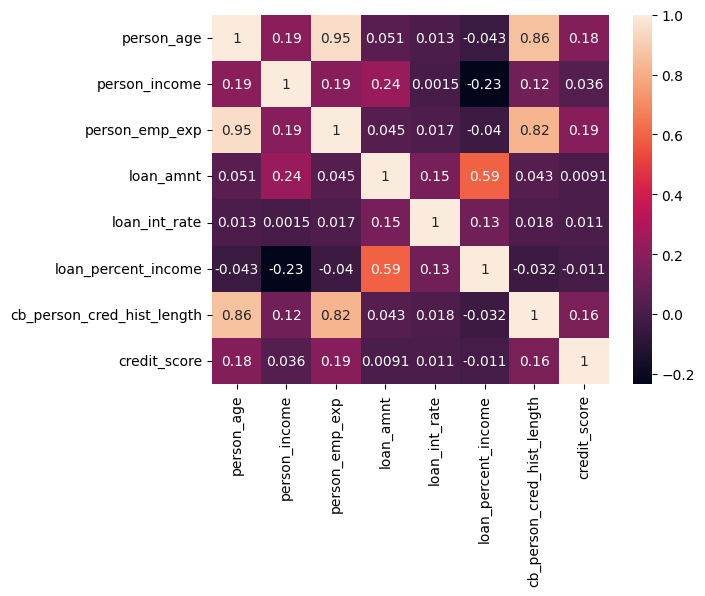

In [80]:
#sns heapmap
sns.heatmap(all_data[num_vars].corr(), annot=True)
plt.show()

Split into train, test and validation data

In [81]:

#split to train and test data
train_data, test_data = train_test_split(
     all_data.copy(), test_size=0.2, random_state=74, stratify=all_data["loan_status"])

#create validation data
train_data, val_data = train_test_split(
     train_data, test_size=0.2, random_state=74, stratify=train_data["loan_status"])

print("Data variables: ", list(train_data.columns))

print(sorted(test_data.columns))

Data variables:  ['person_age', 'person_gender', 'person_education', 'person_income', 'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'previous_loan_defaults_on_file', 'loan_status']
['cb_person_cred_hist_length', 'credit_score', 'loan_amnt', 'loan_int_rate', 'loan_intent', 'loan_percent_income', 'loan_status', 'person_age', 'person_education', 'person_emp_exp', 'person_gender', 'person_home_ownership', 'person_income', 'previous_loan_defaults_on_file']


#Data Preprocessing

Helper functions to preprocess the data. Here we do:
- Standard scaler: we scale numerical columns
- One hot encoding: most models expect numerical data, so we convert categorical columns to numeric

In [82]:
def preprocess(train_data, cat_fills, num_fills,
               scaler=None, ohe=None, is_train=False):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import OneHotEncoder
    cat_list = list(cat_fills.keys())
    num_list = list(num_fills.keys())

    #fillna: cat_fills is a dictionary
    for var in cat_vars:
        this_mode = cat_fills[var][0]
        train_data[var] = train_data[var].fillna(this_mode)
    for var in num_vars:
        this_mean = num_fills[var]
        train_data[var] = train_data[var].fillna(this_mean)

    #scale and one-hot encode
    if is_train:
        scaler = StandardScaler()
        train_data[num_list] = scaler.fit_transform(train_data[num_list])
        ohe = OneHotEncoder(handle_unknown='ignore', #unknown_value=-1,
                            sparse_output=False)
        train_enc = ohe.fit_transform(train_data[cat_list])
    else:
        train_data[num_list] = scaler.transform(train_data[num_list])
        train_data[cat_list] = train_data[cat_list].astype(str)
        train_enc = ohe.transform(train_data[cat_list])
    ohe_cols = [f'{col}_{cat}' for i, col in enumerate(cat_list) for cat in ohe.categories_[i]]
    ohe_cols = [x.replace(':', '_') for x in ohe_cols]
    train_enc = pd.DataFrame(train_enc)
    train_enc.columns=ohe_cols
    #fix issue with a column name

    train_enc[num_list] = train_data[num_list].values

    #train_enc = train_enc.rename(columns={'Accompany_Client_##': 'Accompany_Client_NN'})
    if is_train:
        return train_enc, scaler, ohe
    else:
        return train_enc

if target in train_data.columns:
    y_train = train_data.pop(target)
    y_val = val_data.pop(target)
    y_test = test_data.pop(target)
    #check y_train has no missing values
    print("Missing values for target: ", y_train.isna().sum())

#clean data
#train_data = clean_data(train_data)
#val_data = clean_data(val_data)
#test_data = clean_data(test_data)

#categorical columns
cat_vars = train_data.select_dtypes(exclude='number').columns
num_vars = [x for x in train_data.columns if x not in cat_vars]
cat_fills = train_data[cat_vars].mode().to_dict()
num_fills = train_data[num_vars].mean().to_dict()
X_train, scaler, encoder = preprocess(train_data, cat_fills,
                                      num_fills, is_train=True)
X_val = preprocess(val_data, cat_fills, num_fills,
                   scaler, encoder,is_train=False)
X_test = preprocess(test_data,cat_fills, num_fills,
                   scaler, encoder,is_train=False)
display(X_train)


Missing values for target:  0


,person_gender_female,person_gender_male,person_education_Associate,person_education_Bachelor,person_education_Doctorate,person_education_High_School,person_education_Master,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.043975,-0.129020,0.429801,-0.568023,0.579557,-0.569928,1.070148,0.346319
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,-0.616771,-0.231948,-0.885409,1.332060,0.475809,1.720698,-0.475773,0.822707
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.121211,-0.348498,0.265399,0.698699,-0.347483,1.491635,-0.218120,0.187522
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-1.112330,-0.652961,-0.885409,-0.955957,0.003922,0.002728,-0.475773,1.199849
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.121211,-0.021994,-0.556606,-0.963874,0.208072,-1.142585,0.554841,-2.313519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.947144,-0.486770,-0.885409,-0.409683,-1.465285,0.460853,-0.991080,1.557140
28796,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.947144,-0.005570,-0.885409,1.648741,1.145151,1.262572,-0.991080,0.445566
28797,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,-0.451584,-0.304807,-0.721008,-1.233053,0.539396,-1.257116,-0.475773,0.306619
28798,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,2.521773,0.077348,3.060220,0.065338,0.003922,-0.340866,1.327801,2.192325


# Get a baseline model (logistic regression)

In [83]:
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

#dt = DecisionTreeClassifier()
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_dt = log_reg.predict(X_train)
print("F1 score is: ", f1_score(y_train, y_dt))

F1 score is:  0.7647760719115424


#Tune a LightGBM model

In [84]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'learning_rate': [0.005, 0.01, 0.1],
    'num_leaves': [4, 8, 16, 32],
    'max_depth' : [4, 8, 16, 32, 64],
    'random_state' : [123],
    'n_estimators' : [32, 64, 100, 500],
    }

clf = lg.LGBMClassifier(metric='auc', is_unbalance='true')
tuned_model = RandomizedSearchCV(clf, params, verbose=1, cv=5, n_jobs = -1, n_iter=50)
tuned_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="auc")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 6400, number of negative: 22400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 28800, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.222222 -> initscore=-1.252763
[LightGBM] [Info] Start training from score -1.252763


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(is_unbalance='true', metric='auc'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.1],
                                        'max_depth': [4, 8, 16, 32, 64],
                                        'n_estimators': [32, 64, 100, 500],
                                        'num_leaves': [4, 8, 16, 32],
                                        'random_state': [123]},
                   verbose=1)

In [85]:
print((X_val.columns))

Index(['person_gender_female', 'person_gender_male',
       'person_education_Associate', 'person_education_Bachelor',
       'person_education_Doctorate', 'person_education_High_School',
       'person_education_Master', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'previous_loan_defaults_on_file_No',
       'previous_loan_defaults_on_file_Yes', 'person_age', 'person_income',
       'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'credit_score'],
      dtype='object')


Get important features driving predictions

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

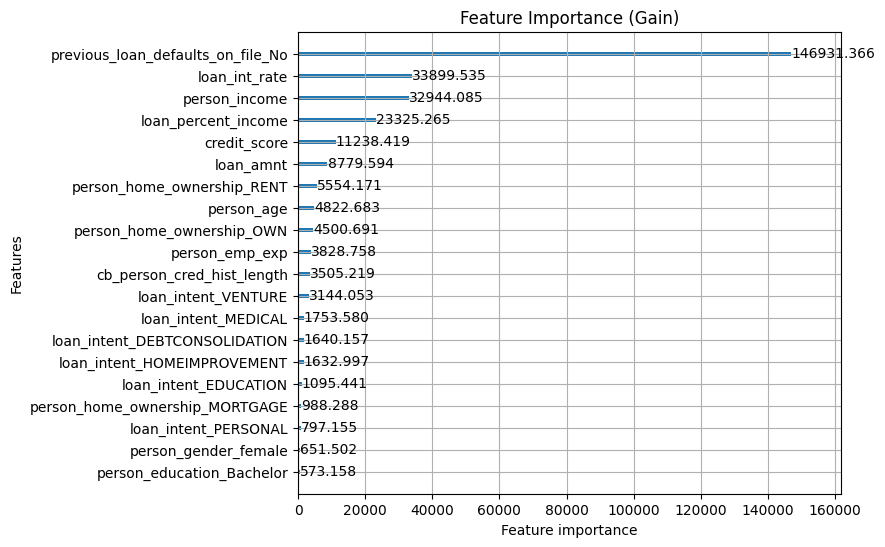

In [86]:
lg.plot_importance(tuned_model.best_estimator_, importance_type="gain", figsize=(7,6), title="Feature Importance (Gain)",max_num_features=20)

In [87]:
print(tuned_model.best_params_)

{'random_state': 123, 'num_leaves': 32, 'n_estimators': 500, 'max_depth': 16, 'learning_rate': 0.1}


#Model Evaluation

Get classification report

In [88]:
class_report = classification_report(y_test, tuned_model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      7000
           1       0.80      0.87      0.84      2000

    accuracy                           0.92      9000
   macro avg       0.88      0.91      0.89      9000
weighted avg       0.93      0.92      0.93      9000



Get metrics

In [109]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
def calculate_metrics(y_train, y_pred):
    auc = roc_auc_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    accuracy = accuracy_score(y_train, y_pred)

    metrics_df = pd.DataFrame({
        'Metric': ['AUC','F1-score', 'Precision', 'Recall', 'Accuracy'],
        'Value': [auc, f1, precision, recall, accuracy],
    })

    return metrics_df

#fit on all train data (including validation data)

best_model = lg.LGBMClassifier(**tuned_model.best_params_, metric='auc', is_unbalance='true')
X_train_all = X_train.copy()
X_train_all[target] = y_train.values
X_val[target] = y_val.values
X_train_all = pd.concat([X_train_all, X_val])
y_train_all = X_train_all.pop(target)
#X_train_all.drop(target, inplace=True)
best_model.fit(X_train_all, y_train_all)
y_pred_train = best_model.predict(X_train_all)
metrics_train = calculate_metrics(y_pred_train, y_train_all)

y_pred = best_model.predict(X_test)
metrics_gbm = calculate_metrics(y_test, y_pred)
print(metrics_gbm)

y_dt = dt.predict(X_test)
metrics_dt = calculate_metrics(y_test, y_dt)

metrics_all = pd.concat([metrics_dt['Value'], metrics_gbm['Value'], metrics_train['Value']], axis=1)
metrics_all.columns = ['Logistic Regression (test)', 'LightGBM (test)', 'LightGBM (train)']
metrics_all.index = metrics_dt['Metric'].values
display(metrics_all)

,Logistic Regression (test),LightGBM (test),LightGBM (train)
AUC,0.835821,0.909893,0.973005
F1-score,0.753020,0.839676,0.971776
Precision,0.774722,0.800817,0.998500
Recall,0.732500,0.882500,0.946445
Accuracy,0.893222,0.925111,0.987111


From the metrics we can see that LightGBM outperformed the baseline in terms of AUC, F1 and other metrics

# Apply explainable AI like SHAP to understand model better

Get feature importance

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

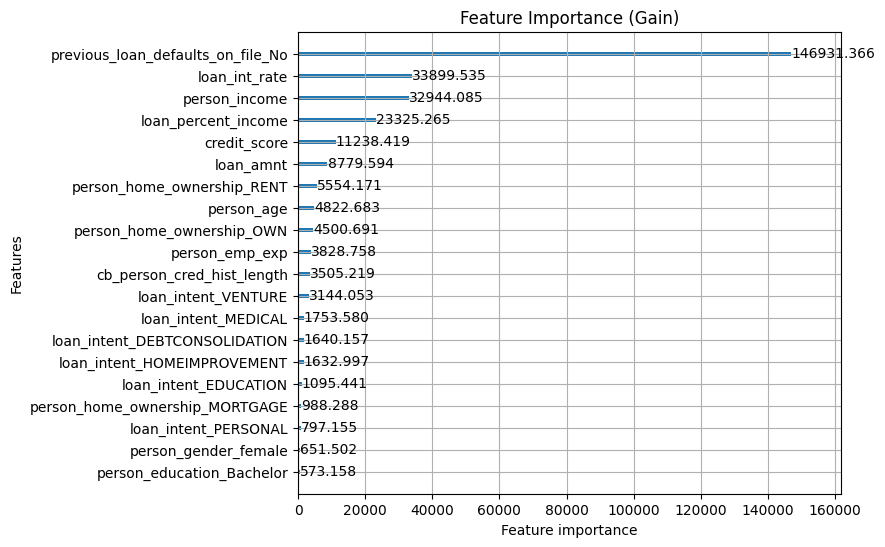

In [90]:
lg.plot_importance(tuned_model.best_estimator_, importance_type="gain", figsize=(7,6), title="Feature Importance (Gain)",max_num_features=20)

SHAP plots

/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


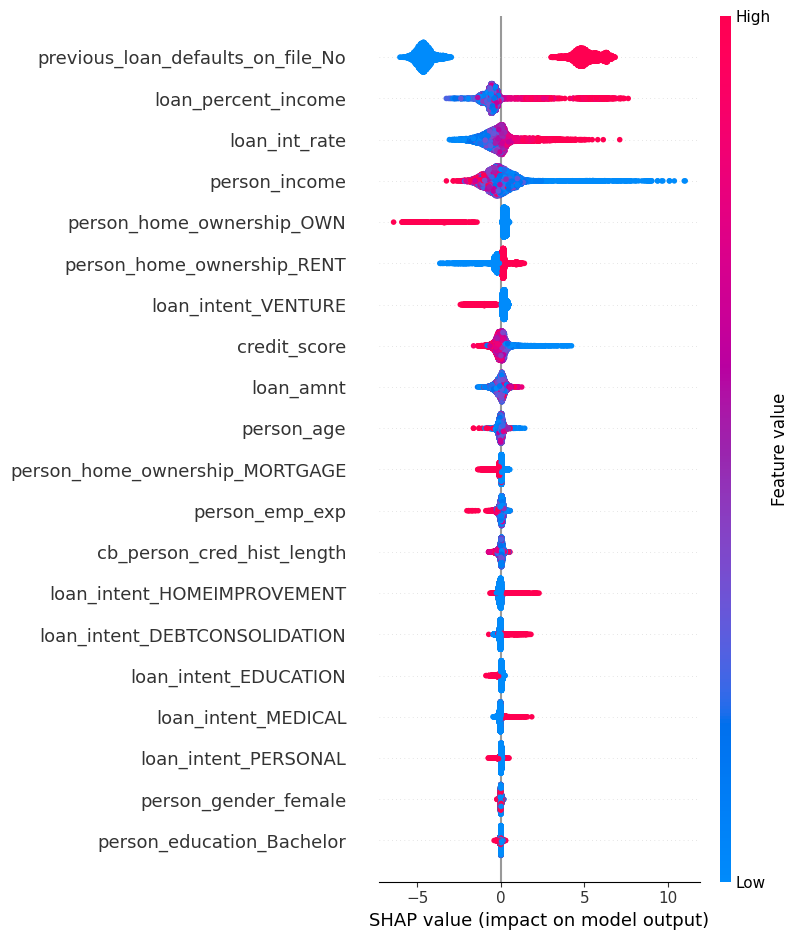

In [114]:
import shap
# Initialize Javascript visualization for SHAP plots
shap.initjs()
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

The SHAP plot (top figure) shows the impact of features on the output prediction.

We can also explain factors behind a specific prediction using lower plot

#Conclusion

For the loan prediction modelling, we accomplished the following:
Data exploration, Modelling and Explainable AI. We also tuned the model using Randomised Search. Another tuning technique to explore in future is HyperOpt(Bayesian search). However, the current model already outperforms the basleine model
